# Final Project: Phase 2

For this phase I was planning on having improved the algorithm and have it working better. I wasn't quite able to get the working but I was able to get any improvements added but I was able to replicate the algorithm as far as I understand the reading the paper

I was able to finish the training process and the cuttlfish algorithm. I implemented five fold cross validation to use due to the low amount of data that we have just as the paper did. Where you break up the training data into five folds and one fold is used for the testing data and the rest is used for training and the testing fold is switched to a different fold and the other test fold is added to the training and then it is trained on that data as well to get an average of of performance. 

I also implemented the cuttlefish algorithm by first generating a population of possible solutions with random different features then you get the "goodness" or accuracy of the model by training a SVM or Support Vector Machine on every solution in the population then you take the top 10% of the population and use them to generate a new population by randomly selecting two of the top 10% and then randomly selecting a feature from each of them and then combining them to make a new solution. Then you get the reflection and the visibility of the new solution and if the new solution is better than the best solution then you replace the best solution with the new solution. 
Then you exchange 10% of the population between the selected and unselected features in the solution and then you check the accuracy and if it is better than the best solution then you replace the best solution with the new solution. Then you generate a randomly generate subset and test it and if it is better than the best solution then you replace the best solution with the new solution. Then you keep repeating this in a loop until you reach the maximum number of iterations or you reach the maximum number of iterations without improving the best solution.

In [1]:
# imports
import cv2
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import svm
from sklearn.metrics import accuracy_score

cwd = os.getcwd()


## Preprocessing

### Datasets used
* https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition
*https://www.kaggle.com/datasets/davilsena/ckdataset



### Unable to use Dataset
Not able to use the JAFFE dataset due to restrictions on the dataset. Including the restriction of not being able to be used for homework, undergraduate projects and course projects. Unless there is another way to access it but I wasn't able to find any other way to access it.
https://zenodo.org/records/3451524



## CK+ Dataset csv file

0: anger
1: disgust
2: fear
3: happy
4: sad
5: surprise
6: neutral
7: contempt

   emotion                                             pixels     Usage
0        6  36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...  Training
1        6  88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...  Training
2        6  9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...  Training
3        6  104 106 108 104 95 50 60 61 58 83 126 133 139 ...  Training
4        6  68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...  Training
test
6
img shape:  2304
size: 48 x 48


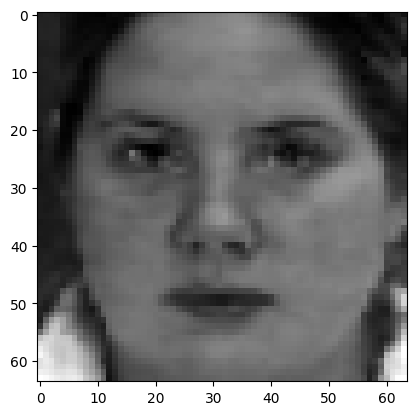

img is gray scale:  True
number of images:  920


In [2]:
# https://www.kaggle.com/datasets/davilsena/ckdataset

# load in datasets
# load in the ckextneded.csv file
ckplus_csv_dataset = pd.read_csv(cwd + '/datasets/ckextended.csv')
print(ckplus_csv_dataset.head())
print("test")
print(ckplus_csv_dataset.iloc[0, 0])

# display the first image in the dataset by getting the data in the first row of the second column
# and reshaping it to 48x48
img = ckplus_csv_dataset.iloc[0, 1]
img = img.split(' ')
img = np.array(img, dtype='float32')
print("img shape: ", img.shape[0])
size = int(np.sqrt(img.shape[0]))
print(f"size: {size} x {size}")
img = img.reshape((size, size))
# upscale image to 64x64
img = cv2.resize(img, (64, 64))
plt.imshow(img, cmap='gray')
plt.show()

# check if img is grey scale
print("img is gray scale: ", img.ndim == 2)

# if ckplus_dataset row in the 3rd column is training, then the image is for training, else it is for testing
# create a list of training and testing images
ckplus_csv_images = []
ckplus_csv_labels = []

for i in range(0, ckplus_csv_dataset.shape[0]):
    img = ckplus_csv_dataset.iloc[i, 1]
    img = img.split(' ')
    img = np.array(img, dtype='float32')
    size = int(np.sqrt(img.shape[0]))
    img = img.reshape((size, size))
    img = cv2.resize(img, (64, 64))
    ckplus_csv_images.append(img)
    ckplus_csv_labels.append(ckplus_csv_dataset.iloc[i, 0])

ckplus_csv_dict = {
    'images': ckplus_csv_images,
    'labels': ckplus_csv_labels
}

print("number of images: ", len(ckplus_csv_images))



In [3]:
def crop_using_viola_johns_algorithm(img, classifier = 'haarcascade_frontalface_default.xml'):
    # load in the haar cascade classifier
    face_cascade = cv2.CascadeClassifier(cwd +'/' +classifier)

    # convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # detect the faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    # draw a rectangle around the face
    for (x, y, w, h) in faces:
        # crop the image
        img = img[y:y+h, x:x+w]
        # resize the image to 48x48
        img = cv2.resize(img, (64, 64))
        # return the image
        return img
    
# croped_image = crop_using_viola_johns_algorithm(cv2.imread(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/images/0/Anger.jpg'))
# test the function
# cv2.imwrite(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/images/0/Anger_cropped.jpg', croped_image.astype(np.uint8))


In [4]:
#load YOLOv3 weights and config file
net = cv2.dnn.readNet(cwd + '/yolov3.weights', cwd + '/yolov3.cfg')

with open(cwd + '/coco.names', 'r') as f:
    classes = f.read().strip().split('\n')
def alternative_face_detector(img):
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward()
    layer_names = net.getUnconnectedOutLayersNames()
    detections = net.forward(layer_names)

    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5 and classes[classID] == "person":
                return True
    return False



In [5]:
classifiers = ['haarcascade_frontalface_default.xml', 'haarcascade_frontalface_alt.xml', 'haarcascade_frontalface_alt2.xml', 'haarcascade_frontalface_alt_tree.xml','haarcascade_profileface.xml']

if (os.listdir(cwd + "/datasets/ckextended/images/") and not os.listdir(cwd + "/datasets/ckextended/cropped_images/")):
    for folder in os.listdir(cwd + "/datasets/ckextended/images/"):
        for file in os.listdir(cwd + "/datasets/ckextended/images/" + folder):
            img = cv2.imread(cwd + "/datasets/ckextended/images/" + folder + "/" + file)
            cropped_image = crop_using_viola_johns_algorithm(img)
            if cropped_image is None:
                print("no face detected")
                break
            if cropped_image is None:
                print("no face detected")
                break
            if alternative_face_detector(cropped_image) == False:
                for classifier in classifiers:
                    cropped_image = crop_using_viola_johns_algorithm(img, classifier)
                    if cropped_image is None:
                        break
                    if alternative_face_detector(cropped_image) == True:
                        break
                
            if cropped_image is None:
                print("no face detected")
                break

            if not os.path.exists(cwd + '/datasets/ckextended/cropped_images'):
                os.makedirs(cwd + '/datasets/ckextended/cropped_images')
            if not os.path.exists(cwd + '/datasets/ckextended/cropped_images/' + folder):
                os.makedirs(cwd + '/datasets/ckextended/cropped_images/' + folder)
            
            cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(cwd + '/datasets/ckextended/cropped_images/' + folder + '/' + file, cropped_image)


In [6]:
def get_number_label_for_string(label):
    anger = ['anger', 'Anger', 'angry', 'Angry']
    disgust = ['disgust', 'Disgust', 'disgusted', 'Disgusted']
    fear = ['fear', 'Fear', 'scared', 'Scared']
    happy = ['happy', 'Happy','happiness', 'Happiness']
    sad = ['sad', 'Sad','sadness', 'Sadness']
    surprised = ['surprised', 'Surprised','surprise', 'Surprise']
    neutral = ['neutral', 'Neutral']
    contempt = ['contempt', 'Contempt']

    if label == anger:
        return 0
    elif label in disgust:
        return 1
    elif label in fear:
        return 2
    elif label in happy:
        return 3
    elif label in sad:
        return 4
    elif label in surprised:
        return 5
    elif label in neutral:
        return 6
    elif label in contempt:
        return 7
    else:
        return -1

In [7]:
ckplus_cropped_images = []
ckplus_cropped_labels = []

for folder in os.listdir(cwd + "/datasets/ckextended/cropped_images/"):
    for file in os.listdir(cwd + "/datasets/ckextended/cropped_images/" + folder):
        img = cv2.imread(cwd + "/datasets/ckextended/cropped_images/" + folder + "/" + file)
        if img is None:
            print("no image")
            break
        ckplus_cropped_images.append(img)
        ckplus_cropped_labels.append(get_number_label_for_string(folder))

ckplus_dict = {
    'images': ckplus_cropped_images,
    'labels': ckplus_cropped_labels
}

## From Kaggle tapakah68/facial-emotion-recognition Dataset and preprocessing

In [8]:
# https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition

# crop images if they arent' already cropped

if (os.listdir(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images') == []):

    classifiers = ['haarcascade_frontalface_default.xml', 'haarcascade_frontalface_alt.xml', 'haarcascade_frontalface_alt2.xml', 'haarcascade_frontalface_alt_tree.xml','haarcascade_profileface.xml']

    # go through the folders in the dataset/kaggle-facial-emotional-recognition-dataset 
    for folder in os.listdir(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/images'):
        for img_name in os.listdir(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/images/' + folder):
            img = cv2.imread(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/images/' + folder + '/' + img_name)
            cropped_image = crop_using_viola_johns_algorithm(img)
            if cropped_image is None:
                print("no face detected")
                break
            if cropped_image is None:
                print("no face detected")
                break
            if alternative_face_detector(cropped_image) == False:
                for classifier in classifiers:
                    cropped_image = crop_using_viola_johns_algorithm(img, classifier)
                    if cropped_image is None:
                        break
                    if alternative_face_detector(cropped_image) == True:
                        break
                
            if cropped_image is None:
                print("no face detected")
                break
            

            # save the image
            # if folder doesn't exist, create it
            if not os.path.exists(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images'):
                os.makedirs(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images')
            if not os.path.exists(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images/' + folder):
                os.makedirs(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images/' + folder)
            

                    # convert the image to grayscale
            
            cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images/' + folder + '/' + img_name, cropped_image)
        # go through the images in the folder
    

   


In [9]:
# load in the cropped images
# create a list of training and testing images

kaggle_images = []
kaggle_labels = []

for folder in os.listdir(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images'):
    for img_name in os.listdir(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images/' + folder):
        img = cv2.imread(cwd + '/datasets/kaggle-facial-emotional-recognition-dataset/cropped_images/' + folder + '/' + img_name)
        if img is None:
            print("img is none")
            break
        kaggle_images.append(img)
        # print(img_name)
        # print(img_name.split('.')[0])
        kaggle_labels.append(get_number_label_for_string(img_name.split('.')[0]))
        
print("kaggle images: ", len(kaggle_images))
print("kaggle labels: ", len(kaggle_labels))

kaggle_dict = {
    'images': kaggle_images,
    'labels': kaggle_labels
}

        

kaggle images:  125
kaggle labels:  125


In [69]:
def generate_hog_features_custom(image):
    # hog = cv2.HOGDescriptor()
    # # hog_features = hog.compute(image)
     # convert the image to grayscale
     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

     image = np.sqrt(image)

     G_x = np.zeros_like(image, dtype=np.float32)
     G_y = np.zeros_like(image, dtype=np.float32)

     for y in range(1, image.shape[0] - 1):
        for x in range(1, image.shape[1] - 1):
            G_x[y, x] = image[y, x-1] - image[y, x+1]
            G_y[y, x] = image[y-1, x] - image[y+1, x]
    
     G = np.sqrt(np.square(G_x) + np.square(G_y))
     theta = np.arctan(G_y, G_x)

     # divide the image into 8x8 cells
     cells = np.zeros((8, 8, 8), dtype=np.float32)
     # for each cell create a local 1-D histogram of gradient orientations that is sorted into 9 angular bins according to their gradient orientation evenly distributed over 0 to 180 degrees
     for y in range(0, image.shape[0] - 8, 8):
        for x in range(0, image.shape[1] - 8, 8):
            for i in range(8):
                for j in range(8):
                    cells[i, j, int(theta[y+i, x+j] / 20)] += G[y+i, x+j]

     # divide the cells within each angular bin divided into blocks with 3x3 cell in size
     # for each block, normalize the histogram using L2-normalization approach
     hog_features = []
     for y in range(0, 6):
        for x in range(0, 6):
            block = cells[y:y+3, x:x+3].flatten()
            block /= np.sqrt(np.sum(np.square(block)) + 1e-5)
            hog_features.extend(block)
     hog_features = np.array(hog_features)

     hog_features = hog_features.flatten()
     return hog_features

In [35]:
def generate_hog_features(image):
    # for image that is 64x64
    # divide the image into 8x8 cells
    cell_size = (8, 8)
    block_size = (2, 2)
    win_size = (64, 64)

    nbins = 9
    img_size = (64, 64)
    hog = cv2.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                        img_size[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
    hog_features = hog.compute(image)
    hog_features = hog_features.flatten()
    return hog_features

In [79]:
def process_fold(train, test, classifier):
    print("size of fold")
    print("train: ", len(train['images']))
    print("test: ", len(test['images']))

    # https://www.researchgate.net/publication/221364666_Feature_reduction_using_Cuttlefish_Optimization_Algorithm
    #CFA algorithm begins by keeping the feature locations (indices) of a particular dataset in a RankedArray list as follows: RankedArray = [0, 1, 2, …, L − 1], where L represents the feature size. 
    #After that, it initializes a population (P) with N random solutions, so that each solution Pi is linked with two subsets: SelectedFeatures and UnselectedFeatures, where SelectedFeatures ⊂ RankedArray, UnselectedFeatures ⊂ RankedArray, and SelectedFeatures ⋂ UnselectedFeatures = Ø

    # ranked_list variable has the indices of the features in the dataset from 0 to image feature size - 1
    ranked_list = np.arange(train['images'][0].shape[0])
    print("ranked list: ", len(ranked_list))

    # get a baseline by taking the label of the majority class and using that as the prediction for all the images
    # get the number of images in each class
    # create a dictionary with the class as the key and the number of images in that class as the value
    class_count = {}
    for label in train['labels']:
        if label in class_count:
            class_count[label] += 1
        else:
            class_count[label] = 1
    print("Train class count: ", class_count)
    # get the class with the most images
    majority_class = max(class_count, key=class_count.get)
    print("Train majority class: ", majority_class)
    # get the accuracy of the majority class
    majority_class_accuracy = class_count[majority_class] / len(train['labels'])
    print("Train majority class accuracy: ", majority_class_accuracy)


    # train and test has following structure {'images': [], 'labels': []}

    # solution has the following structure list of solution dictionaries which contain the indices of the selected and unselected features
    solutions = []
    # N = random.randint(1, train['images'][0].shape[0]-1)
    N =10
    print("N: ", N)
    for random_solution in range(0, N):
        # randomly select the indices of the features no duplicates
        indices_for_selected_features = np.random.choice(ranked_list, len(ranked_list), replace=False)
        # using the indices_for_selected_features take the indices and put those features aat those indices in the selected_features array
        selected_image_features_indices = indices_for_selected_features
        unselected_image_features_indices = np.setdiff1d(ranked_list, selected_image_features_indices)
        solution = {
            'selected_features_indices': selected_image_features_indices,
            'unselected_features_indices': unselected_image_features_indices,
        }
        solutions.append(solution)


    # go through each solution in the solutions list and calculate the goodness of the solution
    solutions_with_goodness = []

    test_last_selected_features_indices = []
    test_dupolication_selected_features_indices = []
    print("solutions: ", len(solutions))
    for solution in solutions:
        # calculate the goodness of the solution
        # goodness = 1 / (1 + error)
        # error = 1 - accuracy
        # accuracy = svm.score(features[solution[0]], features[solution[1]])

        # check if the selected_features_indices is different
        if np.array_equal(solution['selected_features_indices'], test_last_selected_features_indices):
            print("found duplicate solution")
            # remove the solution from the solutions list and exit the loop
            solutions.remove(solution)
            break
        else:
            test_last_selected_features_indices = solution['selected_features_indices']
            


        # get the features at the selected_features_indices
        train_images_with_selected_features =[]
        for i in range(0, len(train['images'])):
            train_images_with_selected_features.append(train['images'][i][solution['selected_features_indices']])
            # print("unique items in train['images'][i][solution['selected_features_indices']]", np.unique(train['images'][i][solution['selected_features_indices']]))
        test_images_with_selected_features = []
        for i in range(0, len(test['images'])):
            test_images_with_selected_features.append(test['images'][i][solution['selected_features_indices']])


        # check if the train_images_with_selected_features is 
        if np.array_equal(train_images_with_selected_features, test_dupolication_selected_features_indices):
            print("found duplicate solution")
            continue
        else:
            test_dupolication_selected_features_indices = train_images_with_selected_features


        classifier.fit(train_images_with_selected_features, train['labels'])
        train_prediction = classifier.predict(train_images_with_selected_features)
        solution['training_accuracy'] = 1 / (1 + (1 - accuracy_score(train['labels'], train_prediction)))
        print("solution goodness: ", solution['training_accuracy'])
        test_prediction = classifier.predict(test_images_with_selected_features)
        solution['testing_accuracy'] = accuracy_score(test['labels'], test_prediction)
        solutions_with_goodness.append(solution)

    # sort the solutions_with_goodness list in descending order of goodness
    solutions_with_goodness.sort(key=lambda x: x['training_accuracy'], reverse=True)

    best_solution = solutions_with_goodness[0]

    # randomly delete 10% of the features from the selected_features_indices
    best_solution['selected_features_indices'] = np.random.choice(best_solution['selected_features_indices'], int(best_solution['selected_features_indices'].shape[0] * 0.9))
    
    # while the stopping criteria is not met, the algorithm performs the following steps:   
    stoping_criteria = 0
    while stoping_criteria !=10:
        # calculat the CFA of each solution within the population_of_solutions
        # for each solution within the population_of_solutions, calculate the CFA
        # print("N", N)
        nHalf = int(N/2)
        K = random.randint(0,nHalf)
        for i in range(0, K-1):
            r = random.randint(0,len(solutions_with_goodness[i]["selected_features_indices"])-1)
            v = len(solutions_with_goodness[i]["selected_features_indices"]) - r
            if (v > len(solutions_with_goodness[i]["unselected_features_indices"])):
                # cut the selected_features_indices to the size of the selected_features_indices
                temp_selected_features_indices = solutions_with_goodness[i]["selected_features_indices"]
            else:
                reflection = random.sample(solutions_with_goodness[i]["selected_features_indices"].tolist(), r)
                visibility = random.sample(solutions_with_goodness[i]["unselected_features_indices"].tolist(), v)
            # new subset union of reflection and visibility
                temp_selected_features_indices = np.union1d(reflection, visibility)
            newSubset = {
                'selected_features_indices': temp_selected_features_indices,
                'unselected_features_indices': np.setdiff1d(ranked_list, temp_selected_features_indices),
            }
            # evaluate new subset using the svm
            # get the features at the selected_features_indices
            train_images_with_selected_features =[]
            for j in range(0, len(train['images'])):
                train_images_with_selected_features.append(train['images'][j][newSubset["selected_features_indices"]])
            test_images_with_selected_features = []
            for j in range(0, len(test['images'])):
                test_images_with_selected_features.append(test['images'][j][newSubset["selected_features_indices"]])

            classifier.fit(train_images_with_selected_features, train['labels'])
            train_prediction = classifier.predict(train_images_with_selected_features)
            
            goodness = 1 / (1 + (1 - accuracy_score(train['labels'], train_prediction)))
            test_prediction = classifier.predict(test_images_with_selected_features)
            test_accuracy = accuracy_score(test['labels'], test_prediction)

            if goodness > solutions_with_goodness[i]['training_accuracy']:
                solutions_with_goodness[i]['training_accuracy'] = goodness
                solutions_with_goodness[i]['testing_accuracy'] = test_accuracy
                solutions_with_goodness[i]['selected_features_indices'] = newSubset["selected_features_indices"]
                solutions_with_goodness[i]['unselected_features_indices'] = np.setdiff1d(ranked_list, newSubset["selected_features_indices"])
            if goodness > best_solution['training_accuracy']:
                best_solution = solutions_with_goodness[i]
        newSubset = best_solution
        T = 5
        for i in range(0, T-1):
            # randomly exchange 10% of the features between the selected and unselected features of the newSubset

            temp_selected_features_indices = np.random.choice(newSubset['selected_features_indices'], int(newSubset['selected_features_indices'].shape[0] * 0.9))

            newSubset = {
                'selected_features_indices': temp_selected_features_indices,
                'unselected_features_indices': np.setdiff1d(ranked_list, temp_selected_features_indices),
            }
                
            # evaluate new subset using the svm
            # get the features at the selected_features_indices
            train_images_with_selected_features =[]
            for i in range(0, len(train['images'])):
                train_images_with_selected_features.append(train['images'][i][newSubset["selected_features_indices"]])
            test_images_with_selected_features = []
            for i in range(0, len(test['images'])):
                test_images_with_selected_features.append(test['images'][i][newSubset["selected_features_indices"]])

            classifier.fit(train_images_with_selected_features, train['labels'])
            train_predictor = classifier.predict(train_images_with_selected_features)
            goodness = 1 / (1 + (1 - accuracy_score(train['labels'], train_predictor)))
            test_predictor = classifier.predict(test_images_with_selected_features)
            test_accuracy = accuracy_score(test['labels'], test_predictor)
            if goodness > best_solution['training_accuracy']:
                newSubset["goodness"] = goodness
                newSubset["testing_accuracy"] = test_accuracy
                best_solution = newSubset
        m = 5
        size = len(best_solution["selected_features_indices"])
        for i in range(0, m-1):
            # randomly delete 10% of the features from the selected_features_indices
            temp_selected_features_indices = np.random.choice(best_solution['selected_features_indices'], int(size * 0.9))
            
            new_subset = {
                'selected_features_indices': temp_selected_features_indices,
                'unselected_features_indices': np.setdiff1d(ranked_list, temp_selected_features_indices),
            }
            # evaluate new subset using the svm
            # get the features at the selected_features_indices
            train_images_with_selected_features =[]
            for i in range(0, len(train['images'])):
                train_images_with_selected_features.append(train['images'][i][new_subset["selected_features_indices"]])
            test_images_with_selected_features = []
            for i in range(0, len(test['images'])):
                test_images_with_selected_features.append(test['images'][i][new_subset["selected_features_indices"]])

            classifier.fit(train_images_with_selected_features, train['labels'])
            train_prediction = classifier.predict(train_images_with_selected_features)
            goodness = 1 / (1 + (1 - accuracy_score(train['labels'], train_prediction)))

            test_prediction = classifier.predict(test_images_with_selected_features)
            test_accuracy = accuracy_score(test['labels'], test_prediction)
            
            if goodness > best_solution['training_accuracy']:
                new_subset["training_accuracy"] = goodness
                new_subset["testing_accuracy"] = test_accuracy
                best_solution = new_subset
            
            for i in range(0, K):
                # randomly generate newsubset
                temp_selected_features_indices = np.random.choice(ranked_list, N)

                new_subset = {
                    'selected_features_indices': temp_selected_features_indices,
                    'unselected_features_indices': np.setdiff1d(ranked_list, temp_selected_features_indices),
                }
                # evaluate new subset using the svm
                # get the features at the selected_features_indices
                train_images_with_selected_features =[]
                for j in range(0, len(train['images'])):
                    train_images_with_selected_features.append(train['images'][j][new_subset["selected_features_indices"]])
                test_images_with_selected_features = []
                for j in range(0, len(test['images'])):
                    test_images_with_selected_features.append(test['images'][j][new_subset["selected_features_indices"]])
                
                classifier.fit(train_images_with_selected_features, train['labels'])
                train_prediction = classifier.predict(train_images_with_selected_features)
                goodness = 1 / (1 + (1 - accuracy_score(train['labels'], train_prediction)))
                test_prediction = classifier.predict(test_images_with_selected_features)
                test_accuracy = accuracy_score(test['labels'], test_prediction)
                if goodness > solutions_with_goodness[i]['training_accuracy']:
                    solutions_with_goodness[i]['training_accuracy'] = goodness
                    solutions_with_goodness[i]['testing_accuracy'] = test_accuracy
                    solutions_with_goodness[i]['selected_features_indices'] = new_subset
                    solutions_with_goodness[i]['unselected_features_indices'] = np.setdiff1d(ranked_list, new_subset)
                if goodness > best_solution['training_accuracy']:
                    best_solution = newSubset
                    best_solution['training_accuracy'] = goodness
        stoping_criteria += 1
    print("best solution: ", best_solution)

    
    results = {
        "training_accuracy": best_solution['training_accuracy'],
        "testing_accuracy": best_solution['testing_accuracy'],
        "selected_features_indices": best_solution['selected_features_indices'],
        "unselected_features_indices": best_solution['unselected_features_indices'],
    }
    return results

        


                    

                

           


## Training and Testing

In [78]:
def train_test(dataset, classifier):
    # split the dataset into five fold cross validation
    # create a list of the indexes of the dataset
    # shuffle the indexes
    # split the indexes into five folds

    # shuffle the dataset
    # create a list of the indexes of the dataset

    # size of the dataset
    results = []



    print("dataset size: ", len(dataset['images']))

    dataset_indexes = np.arange(len(dataset['images']))
    np.random.shuffle(dataset_indexes)
    # split the dataset into five folds
    folds_images = np.array_split(dataset_indexes, 5)
    folds_labels = np.array_split(dataset_indexes, 5)

    # folds_images = np.array_split(dataset["images"], 5)
    # folds_labels = np.array_split(dataset["labels"], 5)
    folds = []
    for i in range(0, len(folds_images)):
        fold = {
            'images': folds_images[i],
            'labels': folds_labels[i]
        }
        folds.append(fold)
    
    # create a list of the accuracies for each fold
    all_accuracy = [] 
    # go through each fold
    for i in range(0, len(folds)):
        testing = folds[i]
        ## all the other folds are training
        training = {
            'images': [],
            'labels': []
        }
        for j in range(0, len(folds)):
            if j != i:
                training['images'].extend(folds[j]['images'])
                training['labels'].extend(folds[j]['labels'])
        
        # get the the class count for the training set
        class_count = {}
        for label in training['labels']:
            if label in class_count:
                class_count[label] += 1
            else:
                class_count[label] = 1
        print("Train class count: ", class_count)
        # get the class with the most images
        majority_class = max(class_count, key=class_count.get)
        print("Train majority class: ", majority_class)
        


        train_image_features = []
        train_image_labels = []
        test_image_features = []
        test_image_labels = []

        for image in  range(len(training["images"])):
            # get the image
            img = dataset['images'][image]
            # get the label
            label = dataset['labels'][image]
            # get the hog features
            hog_features = generate_hog_features(img)
            # add the hog features to the dataset
            train_image_features.append(hog_features)
            train_image_labels.append(label)
        for image in range(len(testing["images"])):
            # get the image
            img = dataset['images'][image]
            # get the label
            label = dataset['labels'][image]
            # get the hog features
            hog_features = generate_hog_features(img)
            # add the hog features to the dataset
            test_image_features.append(hog_features)
            test_image_labels.append(label)
        
        train = {
            'images': train_image_features,
            'labels': train_image_labels
        }
        test = {
            'images': test_image_features,
            'labels': test_image_labels
        }
        print("testing train")
        print(len(train['images']))
        print(len(test['images']))
        result = process_fold(train,test, classifier)
        results.append(result)
    # average the training accuracy for each fold
    average_training_accuracy = 0
    for result in results:
        average_training_accuracy += result['training_accuracy']
    average_training_accuracy /= len(results)
    print("average training accuracy: ", average_training_accuracy)
    # average the testing accuracy for each fold
    average_testing_accuracy = 0
    for result in results:
        average_testing_accuracy += result['testing_accuracy']
    average_testing_accuracy /= len(results)
    print("average testing accuracy: ", average_testing_accuracy)

    return average_training_accuracy, average_testing_accuracy
    



In [80]:

# train with the ckplus_dataset with the svm classifier

#create a support vector machine classifier using sklearn
svm_classifier = svm.SVC()

train_test(ckplus_dict, svm_classifier)


# train with the kaggle dataset with the svm classifier

#create a support vector machine classifier using sklearn
# svm_classifier = svm.SVC()

# train_test(kaggle_dict, svm_classifier)




dataset size:  881
Train class count:  {99: 1, 675: 1, 876: 1, 209: 1, 410: 1, 690: 1, 701: 1, 241: 1, 238: 1, 723: 1, 337: 1, 686: 1, 98: 1, 278: 1, 851: 1, 434: 1, 515: 1, 354: 1, 699: 1, 627: 1, 40: 1, 478: 1, 179: 1, 861: 1, 544: 1, 484: 1, 499: 1, 366: 1, 257: 1, 441: 1, 617: 1, 119: 1, 786: 1, 351: 1, 329: 1, 749: 1, 582: 1, 334: 1, 142: 1, 483: 1, 106: 1, 747: 1, 486: 1, 539: 1, 524: 1, 77: 1, 596: 1, 533: 1, 15: 1, 698: 1, 776: 1, 695: 1, 49: 1, 121: 1, 666: 1, 194: 1, 510: 1, 737: 1, 82: 1, 89: 1, 178: 1, 797: 1, 599: 1, 85: 1, 774: 1, 230: 1, 444: 1, 348: 1, 51: 1, 282: 1, 181: 1, 589: 1, 75: 1, 491: 1, 867: 1, 507: 1, 147: 1, 751: 1, 177: 1, 2: 1, 418: 1, 458: 1, 350: 1, 313: 1, 22: 1, 593: 1, 494: 1, 368: 1, 814: 1, 843: 1, 462: 1, 713: 1, 621: 1, 182: 1, 811: 1, 359: 1, 26: 1, 234: 1, 864: 1, 825: 1, 714: 1, 205: 1, 647: 1, 114: 1, 787: 1, 31: 1, 331: 1, 270: 1, 46: 1, 694: 1, 411: 1, 385: 1, 801: 1, 312: 1, 212: 1, 377: 1, 879: 1, 380: 1, 447: 1, 317: 1, 91: 1, 286: 1, 46

(0.8630912135525002, 0.5289419619928094)